# Data Exploration

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

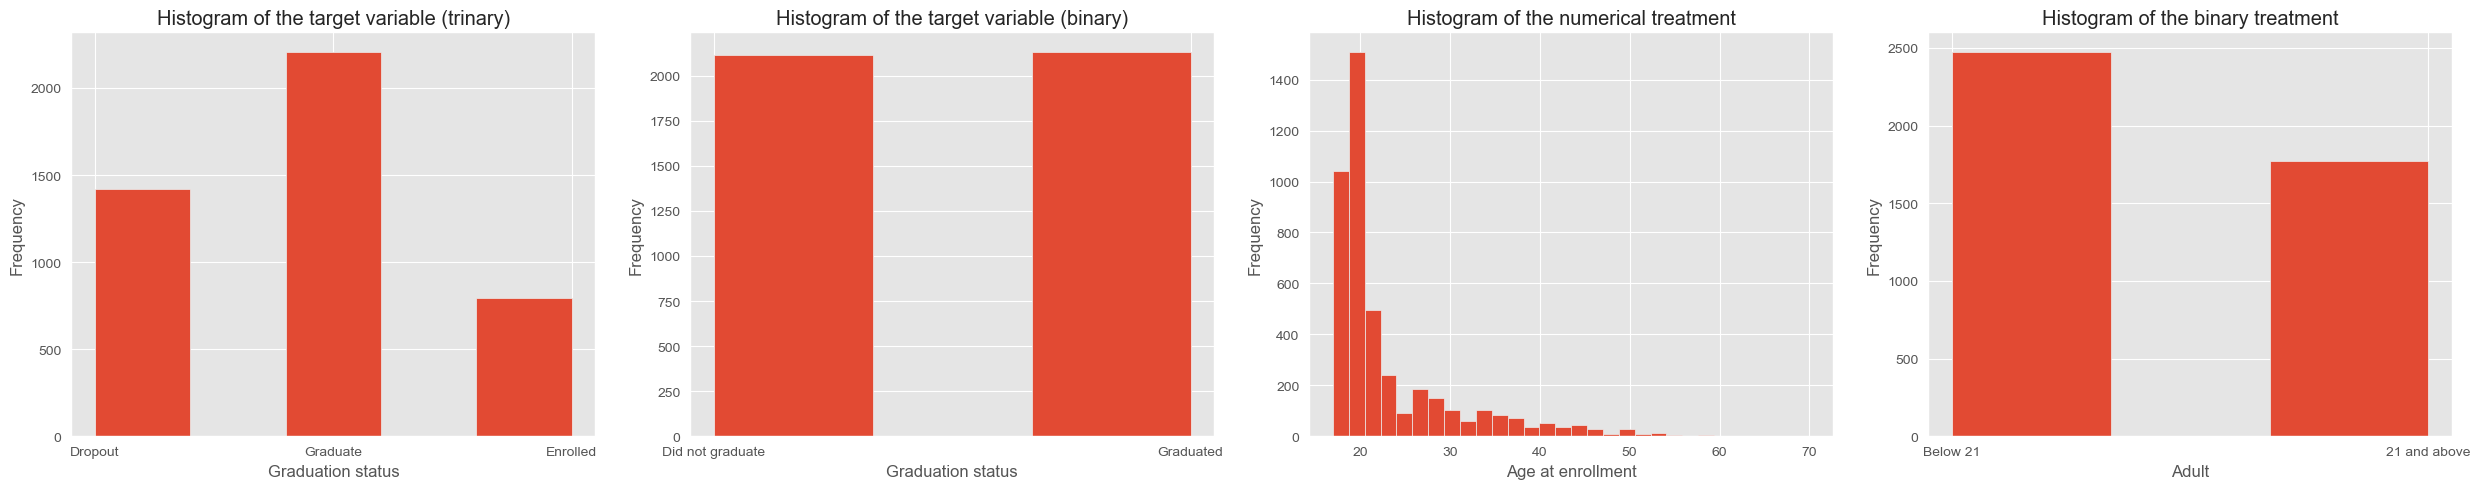

In [11]:

raw_data_df = pd.read_csv('data/raw_data.csv')
processed_data_df = pd.read_csv('data/processed_data.csv')

PREPROCESSED_TARGET_NAME = 'Target'
TARGET_VARIABLE_NAME = 'Target'
NUMERIC_TREATMENT_NAME = 'Age at enrollment'
BINARY_TREATMENT_NAME = 'Adult'

# plot 4 graphs side by side
# The first is the histogram of the target variable from the raw data
# The first is the histogram of the target variable from the processed data
# The second is the histogram of the numerical treatment from the raw data
# The third is the histogram of the binary treatment from the processed data

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

plt.subplots_adjust(wspace=0.7)  # Increase this value to add more space

# plot the histogram of the target variable from the raw data
axs[0].hist(raw_data_df[TARGET_VARIABLE_NAME], bins=5)
axs[0].set_title('Histogram of the target variable (trinary)')
axs[0].set_xlabel('Graduation status')
axs[0].set_ylabel('Frequency')

# plot the histogram of the target variable from the processed data
# The category of 0 should be renamed to 'Did not graduate' and the category of 1 should be renamed to 'Graduated'
axs[1].hist(processed_data_df[TARGET_VARIABLE_NAME], bins=3)
axs[1].set_title('Histogram of the target variable (binary)')
axs[1].set_xlabel('Graduation status')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Did not graduate', 'Graduated'])

# plot the histogram of the numerical treatment from the raw data
axs[2].hist(raw_data_df[NUMERIC_TREATMENT_NAME], bins=30)
axs[2].set_title('Histogram of the numerical treatment')
axs[2].set_xlabel('Age at enrollment')
axs[2].set_ylabel('Frequency')

# plot the histogram of the binary treatment from the processed data.
# The category of 0 should be renamed to ' Below 21' and the category of 1 should be renamed to '21 and above'
axs[3].hist(processed_data_df[BINARY_TREATMENT_NAME], bins=3)
axs[3].set_title('Histogram of the binary treatment')
axs[3].set_xlabel('Adult')
axs[3].set_ylabel('Frequency')
axs[3].set_xticks([0, 1])
axs[3].set_xticklabels(['Below 21', '21 and above'])

# save the plot
PLOTS_DIR = '/Users/gurkeinan/semester6/Causal-Inference/Project/plots'
plt.savefig(f'{PLOTS_DIR}/target_and_treatments_histograms')

plt.tight_layout()
plt.show()

# Checking Common Support

The common support assumption states that each unit has a non-zero probability of receiving each treatment level - $\forall x \in X, P(T=1|X=x) > 0$ and $P(T=0|X=x) > 0$.

In [12]:
# Load the data
data = pd.read_csv('data/processed_data.csv')

# Prepare the feature matrix
X = data.drop(columns=['Adult', 'Target'])
X.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Gender,Scholarship holder,Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,Complete Secondary Education,122.0,Incomplete Secondary Education,Complete Secondary Education,Administrative,Plant and Machine Operators,127.3,1,0,1,0,10.8,1.4,1.74
1,1,15,1,9254,1,Complete Secondary Education,160.0,Complete Secondary Education,Higher Education - Undergraduate,Professionals,Professionals,142.5,1,0,1,0,13.9,-0.3,0.79
2,1,1,5,9070,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,Plant and Machine Operators,124.8,1,0,1,0,10.8,1.4,1.74
3,1,17,2,9773,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Administrative,Professionals,119.6,1,0,0,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,Complete Secondary Education,100.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,Plant and Machine Operators,141.5,0,0,0,0,13.9,-0.3,0.79


In [13]:
# separate numerical and categorical columns
numerical_columns = ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP']
categorical_columns = list(set(X.columns) - set(numerical_columns))

# Standardize the numerical columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# One-hot encode the categorical columns and remove the original columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [14]:
# Estimate propensity scores
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X, data['Adult'])
propensity_scores = propensity_model.predict_proba(X)[:, 1]

# Add propensity scores to the dataframe
data['propensity_score'] = propensity_scores

In [15]:
# Check common support
min_treated = data[data['Adult'] == 1]['propensity_score'].min()
max_treated = data[data['Adult'] == 1]['propensity_score'].max()
min_untreated = data[data['Adult'] == 0]['propensity_score'].min()
max_untreated = data[data['Adult'] == 0]['propensity_score'].max()

print(f"Treated group propensity score range: [{min_treated:.4f}, {max_treated:.4f}]")
print(f"Untreated group propensity score range: [{min_untreated:.4f}, {max_untreated:.4f}]")

if min_treated <= max_untreated and min_untreated <= max_treated:
    print("The common support condition appears to hold.")
else:
    print("The common support condition may not hold.")

# Calculate the overlap coefficient
overlap_min = max(min_treated, min_untreated)
overlap_max = min(max_treated, max_untreated)
overlap_coefficient = (overlap_max - overlap_min) / (max_treated - min_untreated)

print(f"Overlap coefficient: {overlap_coefficient:.4f}")

Treated group propensity score range: [0.0220, 1.0000]
Untreated group propensity score range: [0.0072, 0.9867]
The common support condition appears to hold.
Overlap coefficient: 0.9717


In [16]:
PLOTS_DIR = '/Users/gurkeinan/semester6/Causal-Inference/Project/plots'

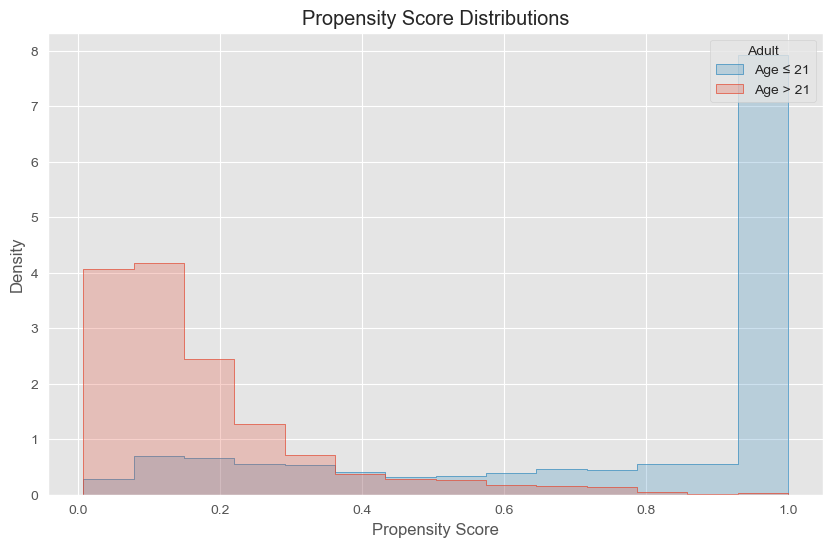

In [17]:
# Visualize propensity score distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='propensity_score', hue='Adult', 
             element='step', stat='density', common_norm=False)
plt.title('Propensity Score Distributions')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Adult', labels=['Age ≤ 21', 'Age > 21'])

# Save the plot
plt.savefig(f'{PLOTS_DIR}/propensity_score_distributions.png')

plt.show()

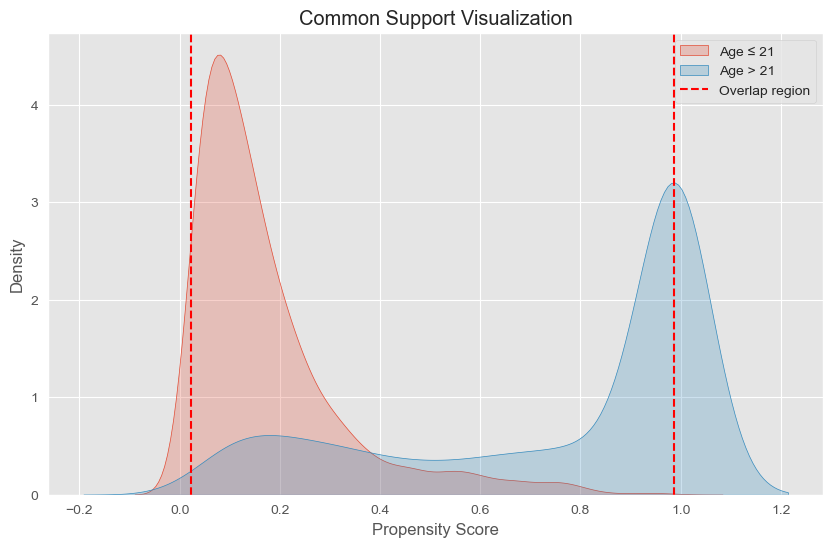

In [18]:
# Visualize common support
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['Adult'] == 0]['propensity_score'], 
            label='Age ≤ 21', shade=True)
sns.kdeplot(data=data[data['Adult'] == 1]['propensity_score'], 
            label='Age > 21', shade=True)
plt.axvline(overlap_min, color='r', linestyle='--', label='Overlap region')
plt.axvline(overlap_max, color='r', linestyle='--')
plt.title('Common Support Visualization')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

# Save the plot
plt.savefig(f'{PLOTS_DIR}/common_support.png')

plt.show()

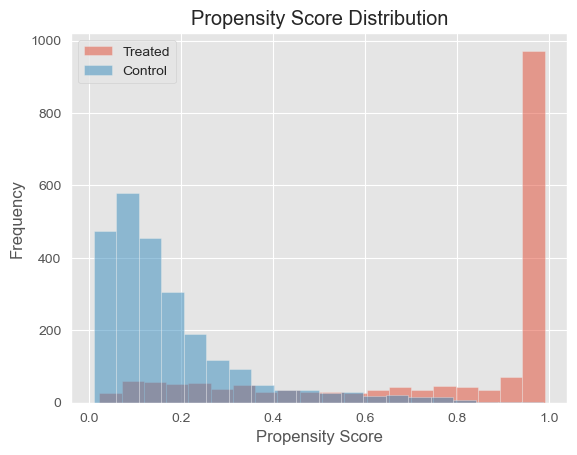

Checking balance in each stratum...
Stratum 0: 45 treated, 805 control
Stratum 1: 95 treated, 755 control
Stratum 2: 193 treated, 656 control
Stratum 3: 591 treated, 259 control
Stratum 4: 849 treated, 1 control
ATE: 0.0007, ATT: 0.1103, ATC: -0.0778
Checking balance in each stratum...
Stratum 0: 40 treated, 811 control
Stratum 1: 93 treated, 757 control
Stratum 2: 187 treated, 662 control
Stratum 3: 606 treated, 244 control
Stratum 4: 848 treated, 1 control
Checking balance in each stratum...
Stratum 0: 32 treated, 818 control
Stratum 1: 74 treated, 776 control
Stratum 2: 197 treated, 652 control
Stratum 3: 592 treated, 258 control
Stratum 4: 849 treated, 1 control
Checking balance in each stratum...
Stratum 0: 40 treated, 814 control
Stratum 1: 77 treated, 769 control
Stratum 2: 177 treated, 672 control
Stratum 3: 625 treated, 225 control
Stratum 4: 848 treated, 2 control
Checking balance in each stratum...
Stratum 0: 40 treated, 810 control
Stratum 1: 91 treated, 759 control
Stratum

KeyboardInterrupt: 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


def read_and_transform_data(data_path):
    data = pd.read_csv(data_path)

    t = data['Adult']
    y = data['Target']
    X = data.drop(columns=['Adult', 'Target'])

    numerical_columns = ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP']
    categorical_columns = list(set(X.columns) - set(numerical_columns))

    # Scaling numerical columns
    scaler = StandardScaler()
    X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

    # One-hot encoding for categorical columns
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

    return X, t, y


def calculate_propensity_scores(X, t):
    propensity_model = LogisticRegression()
    propensity_model.fit(X, t)
    e = propensity_model.predict_proba(X)[:, 1]

    # Clip propensity scores to avoid extreme values
    epsilon = 0.01  # More common threshold for clipping
    e = np.clip(e, epsilon, 1 - epsilon)

    return e


def plot_propensity_scores(e, t):
    plt.hist(e[t == 1], alpha=0.5, label='Treated', bins=20)
    plt.hist(e[t == 0], alpha=0.5, label='Control', bins=20)
    plt.title('Propensity Score Distribution')
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


def calculate_measures_propensity_score_stratification(X, t, y, num_strata=5):
    # Calculate propensity scores
    e = calculate_propensity_scores(X, t)

    # Create strata based on the propensity scores
    strata = pd.qcut(e, num_strata, labels=False)

    # Diagnostic: Check balance in each stratum
    check_balance(X, t, strata)

    # Calculate the ATE, ATT, and ATC for each stratum
    results = []
    for i in range(num_strata):
        mask = (strata == i)
        treated_mask = mask & (t == 1)
        control_mask = mask & (t == 0)

        # Calculate mean outcomes in each stratum for treated and control groups
        treated_mean = y[treated_mask].mean()
        control_mean = y[control_mask].mean()

        # Calculate treatment effect within each stratum
        strata_effect = treated_mean - control_mean

        # Collect results
        results.append({
            'strata': i,
            'n_treated': treated_mask.sum(),
            'n_control': control_mask.sum(),
            'n_total': mask.sum(),
            'effect': strata_effect
        })

    # Convert to DataFrame for easier processing
    strata_df = pd.DataFrame(results)

    # Calculate overall ATE, ATT, and ATC

    # ATE: Weighted by total individuals in each stratum
    ATE = np.sum(strata_df['effect'] * strata_df['n_total'] / strata_df['n_total'].sum())

    # ATT: Weighted by number of treated individuals in each stratum
    ATT = np.sum(strata_df['effect'] * strata_df['n_treated'] / strata_df['n_treated'].sum())

    # ATC: Weighted by number of control individuals in each stratum
    ATC = np.sum(strata_df['effect'] * strata_df['n_control'] / strata_df['n_control'].sum())

    return ATE, ATT, ATC


def check_balance(X, t, strata):
    print("Checking balance in each stratum...")
    for i in np.unique(strata):
        mask = (strata == i)
        treated_count = (mask & (t == 1)).sum()
        control_count = (mask & (t == 0)).sum()
        print(f"Stratum {i}: {treated_count} treated, {control_count} control")


def bootstrap_confidence_intervals(X, t, y, calculate_measures, num_bootstrap=1000, ci_level=95, **kwargs):
    bootstrap_ATE = []
    bootstrap_ATT = []
    bootstrap_ATC = []

    # Combine X, t, and y into a single dataframe for easier resampling
    data = pd.concat([X, t, y], axis=1)

    # Perform bootstrap sampling
    for _ in range(num_bootstrap):
        # Create a bootstrap sample (resample with replacement)
        bootstrap_sample = data.sample(n=len(data), replace=True)

        # Split the bootstrap sample back into X, t, and y
        X_bootstrap = bootstrap_sample.iloc[:, :-2]
        t_bootstrap = bootstrap_sample.iloc[:, -2]
        y_bootstrap = bootstrap_sample.iloc[:, -1]

        # Calculate measures for this bootstrap sample
        ATE, ATT, ATC = calculate_measures(X_bootstrap, t_bootstrap, y_bootstrap, **kwargs)

        # Store the results
        bootstrap_ATE.append(ATE)
        bootstrap_ATT.append(ATT)
        bootstrap_ATC.append(ATC)

    # Calculate percentiles for confidence intervals
    lower_percentile = (100 - ci_level) / 2
    upper_percentile = 100 - lower_percentile

    ATE_CI = np.percentile(bootstrap_ATE, [lower_percentile, upper_percentile])
    ATT_CI = np.percentile(bootstrap_ATT, [lower_percentile, upper_percentile])
    ATC_CI = np.percentile(bootstrap_ATC, [lower_percentile, upper_percentile])

    return ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC


# Main function to run the analysis
if __name__ == '__main__':
    DATA_PATH = '/Users/gurkeinan/semester6/Causal-Inference/Project/code/data/processed_data.csv'

    # Read and transform the data
    X, t, y = read_and_transform_data(DATA_PATH)

    # Plot the propensity scores for diagnostics
    e = calculate_propensity_scores(X, t)
    plot_propensity_scores(e, t)

    # Calculate point estimates for ATE, ATT, and ATC
    ATE, ATT, ATC = calculate_measures_propensity_score_stratification(X, t, y)
    print(f'ATE: {ATE:.4f}, ATT: {ATT:.4f}, ATC: {ATC:.4f}')

    # Calculate confidence intervals using bootstrap
    ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC = bootstrap_confidence_intervals(
        X, t, y, calculate_measures_propensity_score_stratification
    )
    print(f'ATE 95% CI: {ATE_CI}, ATT 95% CI: {ATT_CI}, ATC 95% CI: {ATC_CI}')
